## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 22), (381, 22))

In [9]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr_weighted",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr_weighted', threshold=0.0005)

In [10]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.8859167635630744)

In [11]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'Gender': np.float64(0.0033587871610073483),
 'ERC SUM AVERAGE': np.float64(0.00044384547568043775),
 'ERC ASM': np.float64(0.0009732876500146981),
 'ERC SUM VARIANCE': np.float64(-0.002119076108013429),
 'Hip Clusterhade': np.float64(9.316002621684305e-05),
 'Hip Sum Variance': np.float64(0.002382759531093903),
 'Hip ASM': np.float64(-0.0035500681344675655),
 'ERC CLUSTER SHADE': np.float64(0.0013655568789860961),
 'Hip Contrast': np.float64(-0.0018308963020686742),
 'ERC CONTRAST': np.float64(-0.0008604772851154019),
 'Hip Sum Average': np.float64(-0.0003978107770113981),
 'ERC VARIANCE ': np.float64(0.004050231752799838),
 'Age': np.float64(-0.00046331424796552945),
 'Hip Variance ': np.float64(0.005396189248110583),
 'Hip Correlation': np.float64(0.0028960696939951402),
 'ERC ENTROPY': np.float64(0.0024232989182213505),
 'ERCs_thicknessbaseline': np.float64(0.004007632139627737),
 'ERC CORRELATION': np.float64(0.0003032226301418195),
 'ERCsVolumebaseline': np.float64(0.00549332778

In [12]:
sel.feature_importances_

Gender                      0.009054
ERC SUM AVERAGE             0.011167
ERC ASM                     0.011713
ERC SUM VARIANCE            0.011959
Hip Clusterhade             0.012485
Hip Sum Variance            0.013219
Hip ASM                     0.013822
ERC CLUSTER SHADE           0.014273
Hip Contrast                0.018009
ERC CONTRAST                0.021192
Hip Sum Average             0.021721
ERC VARIANCE                0.023015
Age                         0.024279
Hip Variance                0.024740
Hip Correlation             0.025088
ERC ENTROPY                 0.026980
ERCs_thicknessbaseline      0.038114
ERC CORRELATION             0.039444
ERCsVolumebaseline          0.040925
Hip Entropy                 0.064307
TOTAL_HIPPOCAMPUS_VOLUME    0.103418
MMSE                        0.431077
dtype: float64

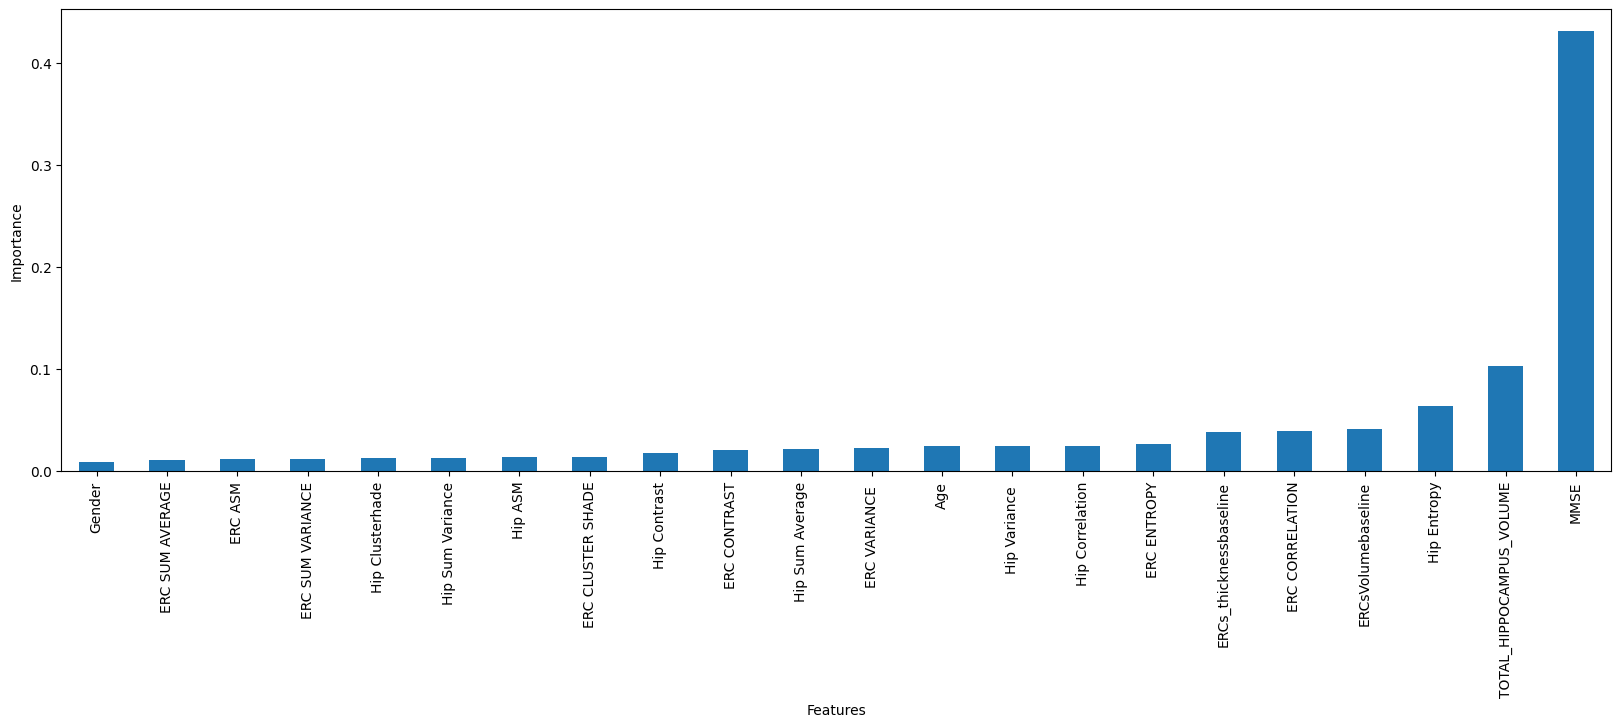

In [13]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

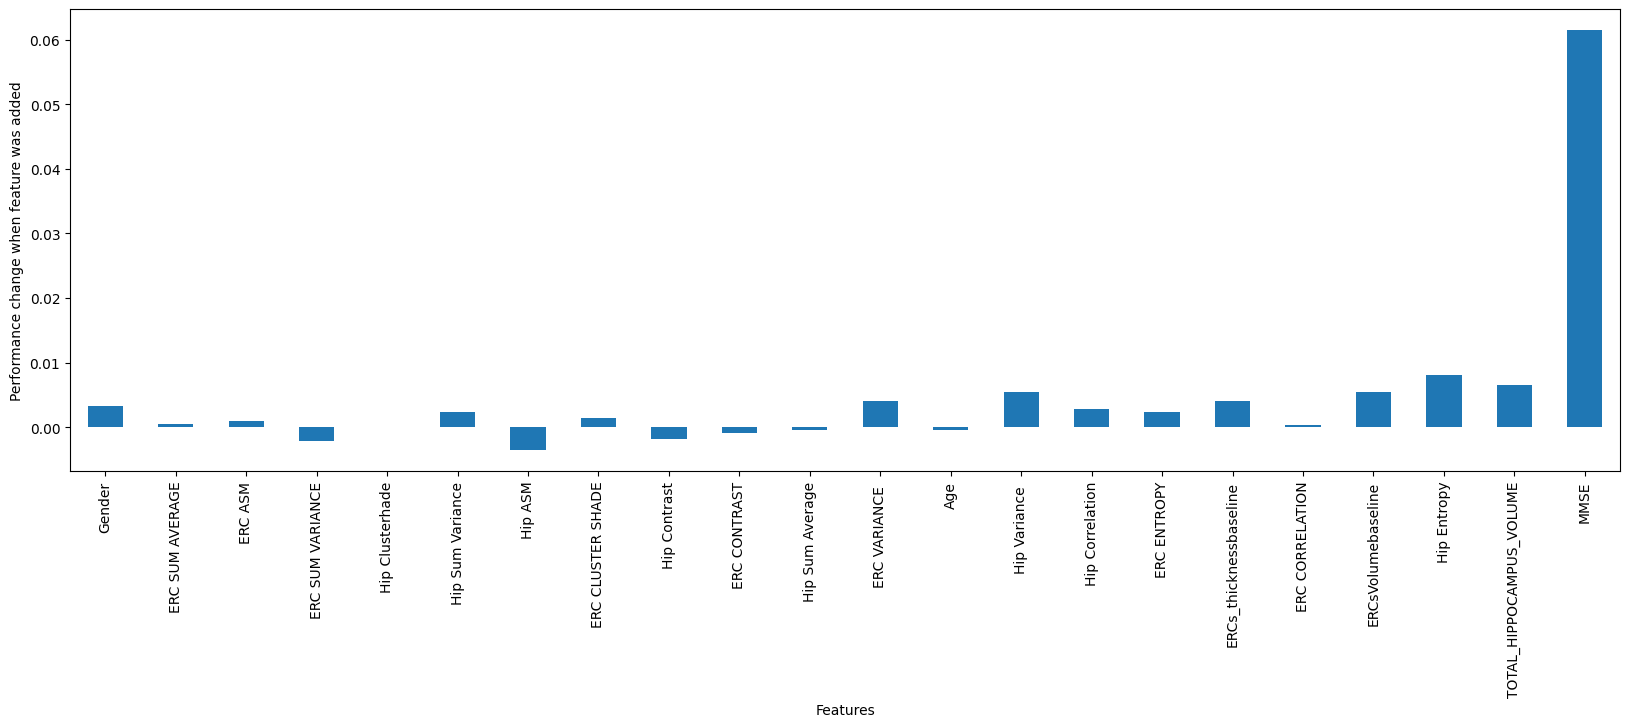

In [14]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [15]:
# Number of features that will be removed

sel.features_to_drop_

['Age',
 'Hip ASM',
 'Hip Contrast',
 'Hip Sum Average',
 'Hip Clusterhade',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC SUM AVERAGE',
 'ERC SUM VARIANCE']

In [16]:
# select features
X_train_t = sel.transform(X_train_knn_t)
X_test_t = sel.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 13), (381, 13))

In [ ]:
X_train_t.columns

Index(['Gender', 'MMSE', 'Hip Correlation', 'Hip Variance ',
       'Hip Sum Variance', 'Hip Entropy', 'ERC ASM', 'ERC VARIANCE ',
       'ERC ENTROPY', 'ERC CLUSTER SHADE', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME'],
      dtype='object')

## Classification Test

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [18]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

In [19]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.702    22                   0.806   
                                                        0.639    13                   0.798   
                  XGBoost             balanced_accuracy 0.993    22                   1.000   
                                                        0.900    13                   1.000   
                  NGBoost             balanced_accuracy 3.685    22                   0.738   
                                                        1.924    13                   0.718   
                  Logistic Regression balanced_accuracy 0.050    22                   0.718   
                                                        0.026    13                   0.719   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.702    22                  0.005   
                                                        0.639    13                  0.006   
                  XGBoost             balanced_accuracy 0.993    22                  0.000   
                                                        0.900    13                  0.000   
                  NGBoost             balanced_accuracy 3.685    22                  0.009   
                                                        1.924    13                  0.011   
                  Logistic Regression balanced_accuracy 0.050    22                  0.006   
                                                        0.026    13                  0.007   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.702    22                  0.686   
                                                        0.639    13                  0.699   
                  XGBoost             balanced_accuracy 0.993    22                  0.680   
                                                        0.900    13                  0.679   
                  NGBoost             balanced_accuracy 3.685    22                  0.659   
                                                        1.924    13                  0.643   
                  Logistic Regression balanced_accuracy 0.050    22                  0.676   
                                                        0.026    13                  0.685   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.702    22                 0.033  
                                                        0.639    13                 0.037  
                  XGBoost             balanced_accuracy 0.993    22                 0.032  
                                                        0.900    13                 0.032  
                  NGBoost             balanced_accuracy 3.685    22                 0.052  
                                                        1.924    13                 0.058  
                  Logistic Regression balanced_accuracy 0.050    22                 0.042  
                                                        0.026    13                 0.034

In [20]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [21]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                             
Boruta            Random Forest       0.167               13             accuracy                   0.795   
                                                                         balanced_accuracy          0.795   
                                                                         precision                  0.816   
                                                                         recall                     0.795   
                                                                         f1_weighted                0.801   
                                                                         roc_auc_ovr_weighted       0.944   
                  XGBoost             0.156               13             accuracy                   1.000   
                                                                         balanced_accuracy          1.000   
                                                                         precision                  1.000   
                                                                         recall                     1.000   
                                                                         f1_weighted                1.000   
                                                                         roc_auc_ovr_weighted       1.000   
                  NGBoost             0.500               13             accuracy                   0.782   
                                                                         balanced_accuracy          0.699   
                                                                         precision                  0.772   
                                                                         recall                     0.782   
                                                                         f1_weighted                0.766   
                                                                         roc_auc_ovr_weighted       0.937   
                  Logistic Regression 0.055               13             accuracy                   0.737   
                                                                         balanced_accuracy          0.711   
                                                                         precision                  0.756   
                                                                         recall                     0.737   
                                                                         f1_weighted                0.744   
                                                                         roc_auc_ovr_weighted       0.893   

                                                                                               Test data  
Feature Selection Classifier          Classification Time Total Features Metric                           
Boruta            Random Forest       0.167               13             accuracy                  0.769  
                                                                         balanced_accuracy         0.751  
                                                                         precision                 0.792  
                                                                         recall                    0.769  
                                                                         f1_weighted               0.776  
                                                                         roc_auc_ovr_weighted      0.894  
                  XGBoost             0.156               13             accuracy                  0.777  
                                                                         balanced_accuracy         0.696  
                                                                         precision                 0.774  
                                                                         recall    